In [1]:
import json
import os
import boto3
from PIL import Image
import io
import base64
from langchain_aws import ChatBedrock
from langchain_core.prompts import ChatPromptTemplate
import json

bedrock = boto3.client(service_name='bedrock-runtime', region_name="us-east-1")

inference_modifier = {
    "max_tokens": 4096,
    "temperature": 1,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"],
}

In [2]:
# MODEL SELECTION
#modelId = "anthropic.claude-3-haiku-20240307-v1:0"
#modelId = "anthropic.claude-3-5-sonnet-20240620-v1:0"
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"

In [3]:
model = ChatBedrock(
    model_id=modelId,
    client=bedrock,
    model_kwargs=inference_modifier,
    streaming=True,
)

In [4]:
# Função para carregar o arquivo, adaptada para tratar JSON e TXT
def load_data(file_path, file_type="txt"):
    with open(file_path, 'r') as file:
        if file_type == "json":
            return json.dumps(json.load(file))  # Serializa o objeto JSON em uma string
        return file.read()  # Carrega como texto
all_pokemon = load_data('pokemon_data.json', file_type="json")
opponents = load_data('movesetElite4Gary.txt', file_type="txt")

In [5]:
system_prompt = """
Você é mestre pokémon do jogo de vídeo-game Pokémon Red,Blue,Yellow ou Green. 
Na tag XML <types></types> você vai encontrar a lista de tipagens de pokémon existentes, em inglês.


<types>
['bug', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water']
</types>

Na tag XML <general_instructions></general_instructions> você vai encontrar algumas guidelines gerais para executar suas tarefas.

<general_instructions>
1. Nunca invente um nome para a pessoa. Utilize EXATAMENTE o nome que foi passado.
2. A pessoa irá passar o tipo do pokémon em portugês, você deve fazer a associação e validar com os nomes presentes em inglês da tag XML <types></types>
3. Nunca use um tipo de pokémon que não está na lista. Pense cuidadosamente sobre isso. 
4. Nunca vincule o tipo do pokémon ao nome da pessoa. 
Use o tipo do pokémon apenas para criar o time de 6 pokémon.
5. No final da criação, adicione uma frase motivacional, relacionada ao tipo de pokémon da pessoa. 
Torne esta frase algo único, motivador e que lembre que a pessoa é uma campeã.
</general_instructions>

Na tag <all_pokemon></all_pokemon> você vai encontrar a lista de todos os pokémon existentes, em inglês, bem como algumas de suas características.
<all_pokemon>{all_pokemon}</all_pokemon>

Na tag <opponents></opponents> você vai encontrar a lista de pokémon dos oponentes que você irá enfrentar.
<opponents>{opponents}</opponents>
"""


In [6]:
my_prompt = """
<instructions>
<step1>
Avalie cuidadosamente se o input do usuário possui qualquer tipo de conteúdo ofensivo, 
impróprio, de baixo calão ou chulo, mesmo que escrito em grafias diferentes. 
Se possuir, responda com um texto educado dizendo que a receita não foi gerada porque 
o nome parece ferir o código de conduta desta aplicação.
</step1>
<step2>
Verifique se as informações necessárias estão disponíveis no prompt. As informações necessárias são:

* Nome do usuário
* Seu tipo de pokémon favorito
* os tipos de pokémon existentes
* os pokémon existentes
* os pokémon dos seus oponents

Se alguma informação estiver faltando de acordo com os seus registros, 
responda o usuário dizendo qual informação está faltando para que você consiga elaborar o time perfeito.
</step2>
<step3>
Você deverá escolher 6 pokémon a partir da tag XML <all_pokemon></all_pokemon> do tipo escolhido pelo usuário (o pokémon pode conter mais de um tipo, basta que um deles seja o escolhido)
e deverá levar em consideração os pokémon que você irá enfrentar <opponents></opponents>, de modo que seu time possua vantagem sobre os oponentes, 
mesmo que algum dos pokémon de seu oponente possua vantagem sobre os nossos, isto é, você deverá levar em consideração todas as tipagens 
que o pokémon a ser escolhido possa ter, bem como suas habilidades e ataques.
Lembrando que você irá disputar o torneio da Elite 4 e no final enfrentará o campeão Gary, a regra do vídeo game diz que você não pode
voltar em um centro pokémon e curar seus pokémon assim que começarmos a enfrentar o primeiro oponente, ou seja, você irá precisar contar somente
com itens de cura e afins para curar, reviver, tirar status de seus pokémon, portanto, uma boa prática é pensar quantos itens em média um jogador
leva consigo neste momento do jogo, bem como, qual pokémon é o melhor para ser escolhido dado esse contexto todo. 
</step3>
<step4>
Pense cuidadosamente sobre as atividades que você vai desempenhar. 
Escreva essas atividades dentro de uma tag <thinking></thinking>
</step4>
<step5>
Escreva o nome do time criado, os pokémon que fazem parte do time e estratégia escolhida acordo com o 
template dentro da tag XML <output_format></output_format>
O nome do time deve ser otimista, inspirador e, sempre com espírito de vencedor.
</step5>
<step6>
Escreva uma frase motivacional em itálico levando em conta o nome do usuário, 
seu tipo escolhido, o nome do time e os pokémon escolhidos.
</step6>
</instructions>

<output_format>
**NOME DO TIME**
*Frase motivacional

Pokémon:

* Pikachu, Lv. 65
* Raichu, Lv. 65
* Electabuzz, Lv. 65
* Magnamite, Lv. 65
* Charmander, Lv. 65
* Arbok, Lv. 65


Estratégia:

* Instruções detalhadas de como preparar o time, como ataques, habilidades envolvidas.

*Conteúdo da frase motivacional*
</output_format>

Na tag XML <user_input></user_input> você vai encontrar o input do usuário.
<user_input>
{}
</user_input>

Faça um resumo das tarefas que deve executar.

Assistant:
<instructions_structure>
1. Verificar se o nome do usuário não possui conteúdo ofensivo, impróprio, de baixo calão ou chulo.
2. Verificar se todas as informações necessárias estão disponíveis no prompt, incluindo o nome do usuário, o tipo do pokémon, a lista de tipos, a lista de pokémon e os pokémon dos nossos adversários.
3. Pensar cuidadosamente sobre as atividades que serão desempenhadas para criar o time perfeito.
4. Escrever o nome do time criado, os pokémon escolhidos e a estratégia elaborada.
5. Escrever uma frase motivacional em itálico, levando em conta o nome do time, seu tipo escolhido e os pokémon escolhidos.
</instructions_structure>

Human: Está correto. 
A resposta deve ser em PT-BR.
Por favor, execute a tarefa.
"""

In [7]:
input_do_usuario = """
Olá. Tudo bem? Eu sou Gabriel e eu gosto do tipo de fogo.
"""

In [9]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt,),
        ("human", "{input}"),
    ]
)

chain = prompt | model

# Inclua todas as variáveis necessárias no dicionário
for chunk in chain.stream(
    {
        "input": my_prompt.format(input_do_usuario),
        "all_pokemon": all_pokemon,
        "opponents": opponents,
    }
):
    print(chunk.content, end="", flush=True)

Muito bem, vamos começar!

<step1>
O nome "Gabriel" não parece conter nenhum conteúdo ofensivo, impróprio ou chulo. Podemos prosseguir com a criação do seu time de pokémon.
</step1>

<step2>
Todas as informações necessárias estão disponíveis:

- Nome do usuário: Gabriel
- Tipo favorito: Fogo
- Lista de tipos de pokémon
- Lista completa de pokémon
- Pokémon dos oponentes que enfrentaremos
</step2>

<step3>
Analisando cuidadosamente as informações, selecionei os seguintes 6 pokémon do tipo fogo ou com vantagem sobre os oponentes:

- Arcanine
- Magmar
- Flareon
- Rapidash
- Ninetales
- Moltres
</step3>

<thinking>
- Ao criar esse time, levei em consideração os pontos fortes e fracos dos pokémon dos oponentes, buscando equilibrar defesa, ataque e velocidade.

- Arcanine é um pokémon poderoso com bons ataques de fogo e movimentos resistentes como Extremespeed. Deve lidar bem contra os tipos água e pedra.

- Magmar possui bons ataques especiais de fogo, mas também ataques físicos poderosos c

In [10]:
image_prompt = """
Você é um especialista em representar imagens de pokémon para demonstrar que são um time. 
Dada o time de 6 pokémon abaixo, crie uma imagem que mostre cada um dos pokémon em questão e os coloque na imagem (os 6 separadamente),
como se fosse uma escalação de time, uma sugestão seria colocar 3 pokémon em cima e 3 embaixo:

**Time Campeões Ardentes**

*Que as chamas da vitória ardam em seu coração, Gabriel! Com determinação e fogo em seus olhos, nada poderá impedir que seu Time Campeões Ardentes triunfe nesta jornada épica!*

Pokémon:

* Arcanine
* Magmar  
* Flareon
* Rapidash
* Ninetales
* Moltres
"""


negative_prompts = [
    "letras ou texto"
]
style_preset = "photographic"
clip_guidance_preset = "NONE"
width = 512

request = json.dumps({
    "text_prompts": (
        [{"text": image_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "seed": 2531586414,
    "steps": 60,
    "style_preset": style_preset,
    #"clip_guidance_preset": clip_guidance_preset,
    #"sampler": sampler,
    "width": width,
})
imageModelId = "stability.stable-diffusion-xl-v1"

response = bedrock.invoke_model(body=request, modelId=imageModelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAQACAIAAAAYynaXAAAJIGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


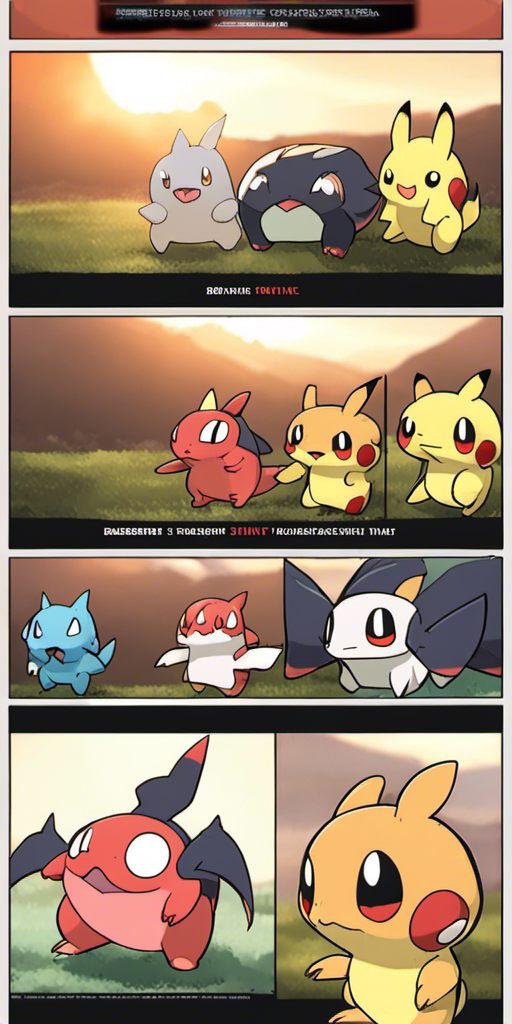

In [11]:
os.makedirs("image", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("image/image_1.png")
image_1